# Assignment

**Target**:

- Have Model Training and Test Accuracy between 96 and 98%
- Reduce number of model parameter to 9-10K

**Results**:
- Parameters: 10,970
- Best Training Accuracy: 99
- Best Test Accuracy: 99

**Analysis**:
- Model parameter has been reduced from 16940 to 10,970
- No of parameter is high compare to benchmarking of 10k
- Adding BN and Droput(in every conv block) has helped to improve the model
- Model Accuracy is not as per target set of 99.4% (this must be consistently shown in your last few epochs, and not a one-time achievement)


# Solution

In [84]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [85]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [86]:
def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
        # nn.init.zeros_(m.bias)

In [87]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
model.apply(weight_init)

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
          Dropout-10           [-1, 20, 22, 22]               0
        MaxPool2d-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             200
      BatchNorm2d-13           [-1, 10, 11, 11]              20
             ReLU-14           [-1, 10,

In [88]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        # transforms.ColorJitter(brightness=0.2, contrast=0.2),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [89]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    correct = 0
    processed = 1
    model.train()
    pbar = tqdm(train_loader)

    for batch_idx, (data, target) in enumerate(pbar):
        # print(len(data))
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        train_losses.append(loss)
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        # print(correct)
        processed += len(data)
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [90]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 12):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

loss=0.13890069723129272 batch_id=468 Accuracy=92.78: 100%|██████████| 469/469 [00:21<00:00, 22.15it/s]



Test set: Average loss: 0.0933, Accuracy: 9712/10000 (97%)



loss=0.04291741922497749 batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:21<00:00, 22.03it/s]



Test set: Average loss: 0.0596, Accuracy: 9810/10000 (98%)



loss=0.042173948138952255 batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:20<00:00, 22.48it/s]



Test set: Average loss: 0.0475, Accuracy: 9848/10000 (98%)



loss=0.024816149845719337 batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:21<00:00, 22.32it/s]



Test set: Average loss: 0.0434, Accuracy: 9858/10000 (99%)



loss=0.0102304145693779 batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:20<00:00, 22.39it/s]



Test set: Average loss: 0.0383, Accuracy: 9886/10000 (99%)



loss=0.03596939519047737 batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]



Test set: Average loss: 0.0315, Accuracy: 9906/10000 (99%)



loss=0.014356124214828014 batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:21<00:00, 22.05it/s]



Test set: Average loss: 0.0352, Accuracy: 9894/10000 (99%)



loss=0.047672536224126816 batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:20<00:00, 22.35it/s]



Test set: Average loss: 0.0363, Accuracy: 9884/10000 (99%)



loss=0.011466667987406254 batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:20<00:00, 22.55it/s]



Test set: Average loss: 0.0307, Accuracy: 9906/10000 (99%)



loss=0.008900930173695087 batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:20<00:00, 22.37it/s]



Test set: Average loss: 0.0291, Accuracy: 9920/10000 (99%)



loss=0.050918664783239365 batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:20<00:00, 22.40it/s]



Test set: Average loss: 0.0295, Accuracy: 9908/10000 (99%)



In [91]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Test Accuracy')

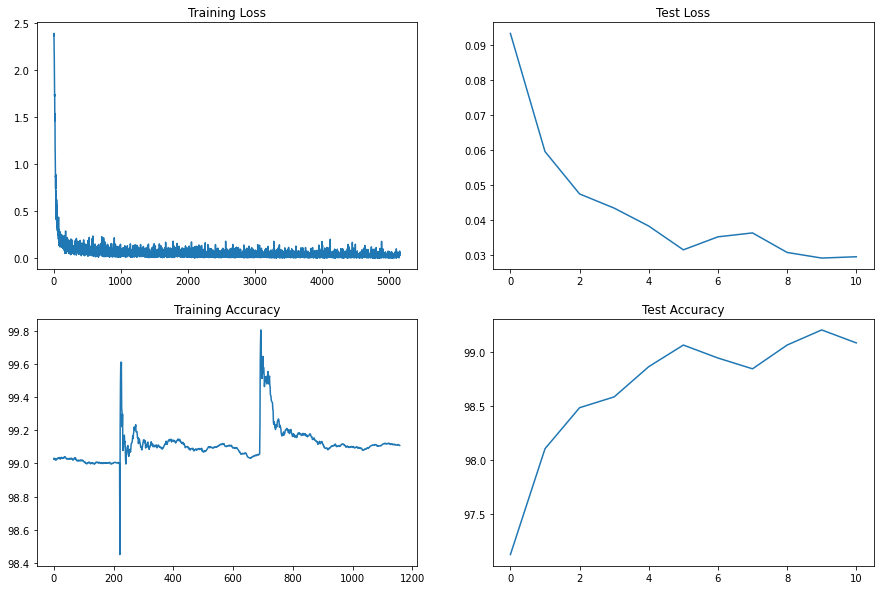

In [92]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")